In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt


Enter the coordinates of node 1 of 4 in the format (x,y): 0,0

Enter the restrictions on node 1 of 4 in the format (a,b). If the node is restricted in x,y direction please write 1, if it is not bound please write 0: 0,1

what is the angle roller is at. Specify the angle in degrees: 45

Enter the coordinates of node 2 of 4 in the format (x,y): 0,10

Enter the restrictions on node 2 of 4 in the format (a,b). If the node is restricted in x,y direction please write 1, if it is not bound please write 0: 1,1

Enter the coordinates of node 3 of 4 in the format (x,y): 12,6

Enter the restrictions on node 3 of 4 in the format (a,b). If the node is restricted in x,y direction please write 1, if it is not bound please write 0: 0,0

Enter the coordinates of node 4 of 4 in the format (x,y): 12,0

Enter the restrictions on node 4 of 4 in the format (a,b). If the node is restricted in x,y direction please write 1, if it is not bound please write 0: 0,0
Enter Material for Bar A (A for Aluminium and S

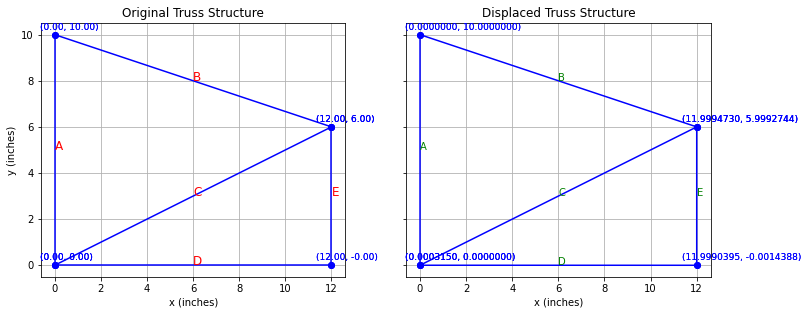

In [12]:
#Youngs modulus (For steel and aluminum)
steel = 30 * 10**6 
alum = 11 * 10**6

coordinates = []
node_bounds = []
total_nodes = 4
total_elements = 5

for i in range(total_nodes): 
    node = input(f"\nEnter the coordinates of node {i+1} of {total_nodes} in the format (x,y): ") #collecting node values 
    x, y = [float(value) for value in node.strip("()").split(',')]
    coordinates.append([x,y])
    # boundary conditions on each node 
    boundaries = input(f"\nEnter the restrictions on node {i+1} of {total_nodes} in the format (a,b). If the node is restricted in x,y direction please write 1, if it is not bound please write 0: ")
    a, b = [float(value) for value in boundaries.strip("()").split(',')]
    node_bounds.append([i,a,b])
    
    #If the node is bound only from one direction but is free on the other coordinate then it means that it is on roller
    
    if (a == 1 or b == 1) and (a != 1 or b != 1):
        roller = float(input("\nwhat is the angle roller is at. Specify the angle in degrees: "))

element_letters = []
predefined_letters = ['A', 'B', 'C', 'D', 'E']

nodes = np.array(coordinates)
boundary_cond = np.array(node_bounds)
K, boundary, bar_num,bars,unitvec, properties, lengths = MakeTruss(boundary_cond)
print("\n------------------------------------------------------------------------------------------")

displacements,reactions, stress = Results(K, boundary, bar_num,unitvec, properties, lengths)

print("\n------------------------------------------------------------------------------------------")

displaced = np.zeros_like(nodes)
displaced = nodes + displacements.reshape(-1, 2)
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for i, bars in enumerate(bar_num):
    node1, node2 = nodes[bars[0]], nodes[bars[1]]
    displaced_1, displaced_2 = displaced[bars[0]], displaced[bars[1]]
    
    axis1.plot([node1[0], node2[0]], [node1[1], node2[1]], 'bo-')
    axis1.annotate(f"({displaced_1[0]:.2f}, {displaced_1[1]:.2f})", (displaced_1[0], displaced_1[1]), textcoords="offset points", xytext=(-15, 5), fontsize=9, color='blue')
    axis1.annotate(f"({displaced_2[0]:.2f}, {displaced_2[1]:.2f})", (displaced_2[0], displaced_2[1]), textcoords="offset points", xytext=(-15, 5), fontsize=9, color='blue')
    axis1.annotate(f"{predefined_letters[i]}", (0.5 * (node1[0] + node2[0]), 0.5 * (node1[1] + node2[1])), fontsize=12, color='red')

    #axis 2

    axis2.plot([displaced_1[0], displaced_2[0]], [displaced_1[1], displaced_2[1]], 'bo-')
    axis2.annotate(f"({displaced_1[0]:.7f}, {displaced_1[1]:.7f})", (displaced_1[0], displaced_1[1]), textcoords="offset points", xytext=(-15, 5), fontsize=9, color='blue')
    axis2.annotate(f"({displaced_2[0]:.7f}, {displaced_2[1]:.7f})", (displaced_2[0], displaced_2[1]), textcoords="offset points", xytext=(-15, 5), fontsize=9, color='blue')
    axis2.annotate(f"{predefined_letters[i]}", (0.5 * (displaced_1[0] + displaced_2[0]), 0.5 * (displaced_1[1] + displaced_2[1])), fontsize=10, color='green')

axis1.set_aspect('equal', 'box')
axis1.set_title("Original Truss Structure")
axis1.set_xlabel('x (inches)')
axis1.set_ylabel('y (inches)')
axis1.grid(True)

axis2.set_aspect('equal', 'box')
axis2.set_title("Displaced Truss Structure")
axis2.set_xlabel('x (inches)')
axis2.grid(True)

plt.show()


axis2.set_aspect('equal', 'box')
axis2.set_title("Displaced Truss Structure")
axis2.set_xlabel('x (inches)')
axis2.grid(True)

plt.show()

def Results( K, boundary, bar,unit, properties, lengths):
    forces = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [2, 0, 0],
    [3, 0, 0],
    ])

    magnitude = float(input(f"Enter the Force acting on the truss in lb/inch: ")) # arbitrary force magnitude, modify as needed
    angle = float(input(f"Enter the angle at which the force is acting on Truss (CCW from x-plane): ")) # arbitrary force magnitude, modify as needed  # degrees
    forces[3, 1] = magnitude * math.cos(math.radians(angle))
    forces[3, 2] = magnitude * math.sin(math.radians(angle))
    
    F = np.zeros(8)
    for f in forces:
        node, x, y = f
        node = int(node)
        F[2*node] = x
        F[2*node+1] = y
       

    displacements = np.linalg.solve(K, F)

    # Calculate reactions
    reactions = np.zeros((boundary.shape[0], 2))
    for i, bc in enumerate(boundary):
        node, x, y = bc
        node = int(node)
        if x or y or (x and y):
            reaction = np.dot(K[2*node:2*node+2, :], displacements)
            reactions[i] = reaction
            
            

    # Calculate stress in all elements
    stress = np.zeros(5)
    for i, bars in enumerate(bar):
        E, _ = properties[i]
        length = lengths[i]
        unit_vec = unit[i]

        idx1_start, idx1_end = 2*bars[0], 2*bars[0]+2
        idx2_start, idx2_end = 2*bars[1], 2*bars[1]+2

        displacement1 = displacements[idx1_start:idx1_end]
        displacement2 = displacements[idx2_start:idx2_end]

        displacement = displacement1 - displacement2
        local_displacement = np.dot(unit_vec, displacement)
        stress[i] = E * local_displacement / length

    
    for i, displacement in enumerate(displacements.reshape(-1, 2)):
        print(f"Node {i}: dx = {displacement[0]:.2e}, dy = {displacement[1]:.2e}")



    print("\nReactions:")
    for i, reaction in enumerate(reactions):
        print(f"Node {i}: Rx = {reaction[0]:.2e}, Ry = {reaction[1]:.2e}")

    print("\nStress in elements:")
    for i, stress_value in enumerate(stress):
        print(f"Element {i}: stress = {stress_value:.2e} psi")

    return displacements, reactions, stress

def MakeMatrix(num_nodes, num_elements, properties, lengths, unitvec, bar,boundary):
    K = np.zeros((2*num_nodes, 2*num_nodes))
    
    for i, bar in enumerate(bar):
        E, A = properties[i]
        length = lengths[i]
        unit_vector = unitvec[i]
        k = E*A/length

        # Local stiffness matrix
        k_temp = np.array([
                    [k, 0, -k, 0],
                    [0, k, 0, -k],
                    [-k, 0, k, 0],
                    [0, -k, 0, k]
        ])
        # Local to global transformation matrix
        T = np.array([
            [unit_vector[0], 0, unit_vector[1], 0],
            [0, unit_vector[0], 0, unit_vector[1]],
            [unit_vector[1], 0, -unit_vector[0], 0],
            [0, unit_vector[1], 0, -unit_vector[0]]
        ])

        # Global stiffness matrix for element
        k_bar = np.dot(T.T, np.dot(k_temp, T))

        # Assemble global stiffness matrix
        for a in range(2):
            for b in range(2):
                K[2*bar[a]:2*bar[a]+2, 2*bar[b]:2*bar[b]+2] += k_bar[a*2:a*2+2, b*2:b*2+2]
        
        for bc in boundary:
            node, constraint_x, constraint_y = bc
            node = int(node)
            if constraint_x:
                K[2*node, :] = 0
                K[:, 2*node] = 0
                K[2*node, 2*node] = 1
            if constraint_y:
                K[2*node+1, :] = 0
                K[:, 2*node+1] = 0
                K[2*node+1, 2*node+1] = 1
                
    return K, boundary,unitvec, properties, lengths
   
def MakeTruss(boundary_cond):
    num_elements = 5
    num_nodes = 4

    element_connectivity_num = [[0, 1], [1, 2], 
                             [0,2] ,
                             [0, 3] ,
                             [2, 3]]
    
    element_connectivity = [[nodes[0], nodes[1]], [nodes[1], nodes[2]], 
                             [nodes[0], nodes[2]] ,
                             [nodes[0], nodes[3]] ,
                             [nodes[2], nodes[3]]]
    
    bar_num = np.array(element_connectivity_num)
    bars = np.array(element_connectivity)
    lengths = np.zeros(num_elements)
    unit = np.zeros((num_elements, 2))
    for i,bar in enumerate(bars):
        node1 = bar[0]
        node2 = bar[1]
        x = abs(node1[0]-node2[0])
        y = abs(node1[1]-node2[1])
        length = math.sqrt(x**2+y**2)
        lengths[i] = length
        unit[i] = [x/length,y/length]
    props = []
    for i, letter in enumerate(predefined_letters):
        A = 0
        E = ''
        prop = input(f"Enter Material for Bar {letter} (A for Aluminium and S for Steel): ")
        if prop == "A":
            E = alum
            A = math.pi*(0.4**2)
        else:
                E = steel
                A = math.pi*(0.5**2)
        props.append([E,A])
    properties = np.array(props)
    
    K, boundary,unitvec, properties, lengths = MakeMatrix(num_nodes,num_elements,properties,lengths,unit,bar_num,boundary_cond)
    return K, boundary,bar_num,bars,unitvec, properties, lengths
